In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings('ignore')
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.max_columns', None)

df = pd.read_csv("../data/processed/ghana_banking_master.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date").sort_index()

# 1. Statistical Analysis of NPL Drivers
## Understanding Macroeconomic Drivers and Shock Propagation in Ghana's Banking Sector

In [2]:
# Multiple Regression Analysis 

y = df['Non Performing Loan Ratio']
X_vars = ['Monetary Policy Rate (%)', 'Consumer Price Index, All Items', 
          'USD Exchange Rate, monthly averages', 'Total Liquidity (M2+)',
          'Gold Price (Realised Gold Price)', 'GDP_Real', 
          'Capital Adequacy Ratio', 'Return on Assets']
X = df[X_vars]

# Adding a constant and fitting OLS model
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

print("\n" + model.summary().as_text())

coef_data = pd.DataFrame({
    'Variable': model.params.index[1:],  
    'Coefficient': model.params.values[1:],
    'P-value': model.pvalues.values[1:],
    'Std Err': model.bse.values[1:]
})
coef_data = coef_data.sort_values('Coefficient', ascending=False)
coef_data['Significant'] = coef_data['P-value'] < 0.05

print("\n" + "=" * 70)
print("REGRESSION COEFFICIENTS SUMMARY")
print("=" * 70)
print(coef_data.to_string(index=False))


                                OLS Regression Results                               
Dep. Variable:     Non Performing Loan Ratio   R-squared:                       0.597
Model:                                   OLS   Adj. R-squared:                  0.579
Method:                        Least Squares   F-statistic:                     32.96
Date:                       Wed, 04 Feb 2026   Prob (F-statistic):           2.04e-31
Time:                               22:32:20   Log-Likelihood:                -422.19
No. Observations:                        187   AIC:                             862.4
Df Residuals:                            178   BIC:                             891.5
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

The OLS results act as the Baseline for this project. While the high R-squared suggests a strong fit, the statistical diagnostic notes (Multicollinearity and Autocorrelation) highlight why a simple regression isn't enough for complex time-series data. This justifies our move to the more advanced Vector Autoregression (VAR) model to capture the dynamic, lagged impacts of these shocks.

In [8]:
# Stationarity Testing - Augmented Dickey-Fuller Test

print("\n" + "=" * 70)
print("STATIONARITY ANALYSIS - Augmented Dickey-Fuller Test")
print("=" * 70)
print("(Required for VAR modeling: all variables must be stationary)")

adf_results = {}
variables_to_test = ['Non Performing Loan Ratio', 'Monetary Policy Rate (%)', 
                     'Consumer Price Index, All Items', 'USD Exchange Rate, monthly averages',
                     'Total Liquidity (M2+)', 'GDP_Real']

for var in variables_to_test:
    result = adfuller(df[var].dropna(), autolag='AIC')
    adf_results[var] = {
        'Test Statistic': result[0],
        'P-value': result[1],
        'Critical Value (5%)': result[4]['5%'],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    }

adf_df = pd.DataFrame(adf_results).T
print("\n" + adf_df.to_string())

# For non-stationary variables, test first differences
print("\n\nTesting First Differences (ΔY):")
diff_adf_results = {}
for var in variables_to_test:
    result = adfuller(df[var].diff().dropna(), autolag='AIC')
    diff_adf_results[var] = {
        'Test Statistic': result[0],
        'P-value': result[1],
        'Stationary': 'Yes' if result[1] < 0.05 else 'No'
    }

diff_adf_df = pd.DataFrame(diff_adf_results).T
print("\n" + diff_adf_df[['Test Statistic', 'P-value', 'Stationary']].to_string())


STATIONARITY ANALYSIS - Augmented Dickey-Fuller Test
(Required for VAR modeling: all variables must be stationary)

                                    Test Statistic   P-value Critical Value (5%) Stationary
Non Performing Loan Ratio                -1.743868  0.408664            -2.87738         No
Monetary Policy Rate (%)                 -1.823972  0.368627           -2.877467         No
Consumer Price Index, All Items           0.545878  0.986203           -2.878595         No
USD Exchange Rate, monthly averages      -1.451335  0.557433           -2.877644         No
Total Liquidity (M2+)                     5.013786       1.0           -2.878298         No
GDP_Real                                  0.044295  0.962046           -2.878396         No


Testing First Differences (ΔY):

                                    Test Statistic   P-value Stationary
Non Performing Loan Ratio                -7.567184       0.0        Yes
Monetary Policy Rate (%)                  -4.53096  0.000173

The ADF test served as a diagnostic pivot point. The discovery of non-stationarity in the raw levels necessitated the use of Integrated of order 1,I(1) modeling techniques, ensuring that the final insights on credit risk propagation are mathematically grounded and robust against time-series bias.


SHOCK PROPAGATION ANALYSIS - Vector Autoregression (VAR) Model

VAR Model fitted with 8 optimal lags (based on AIC)
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Feb, 2026
Time:                     23:09:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    12.2127
Nobs:                     178.000    HQIC:                   10.8100
Log likelihood:          -1755.22    FPE:                    19351.9
AIC:                      9.85320    Det(Omega_mle):         9801.10
--------------------------------------------------------------------
Results for equation Non Performing Loan Ratio
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                              

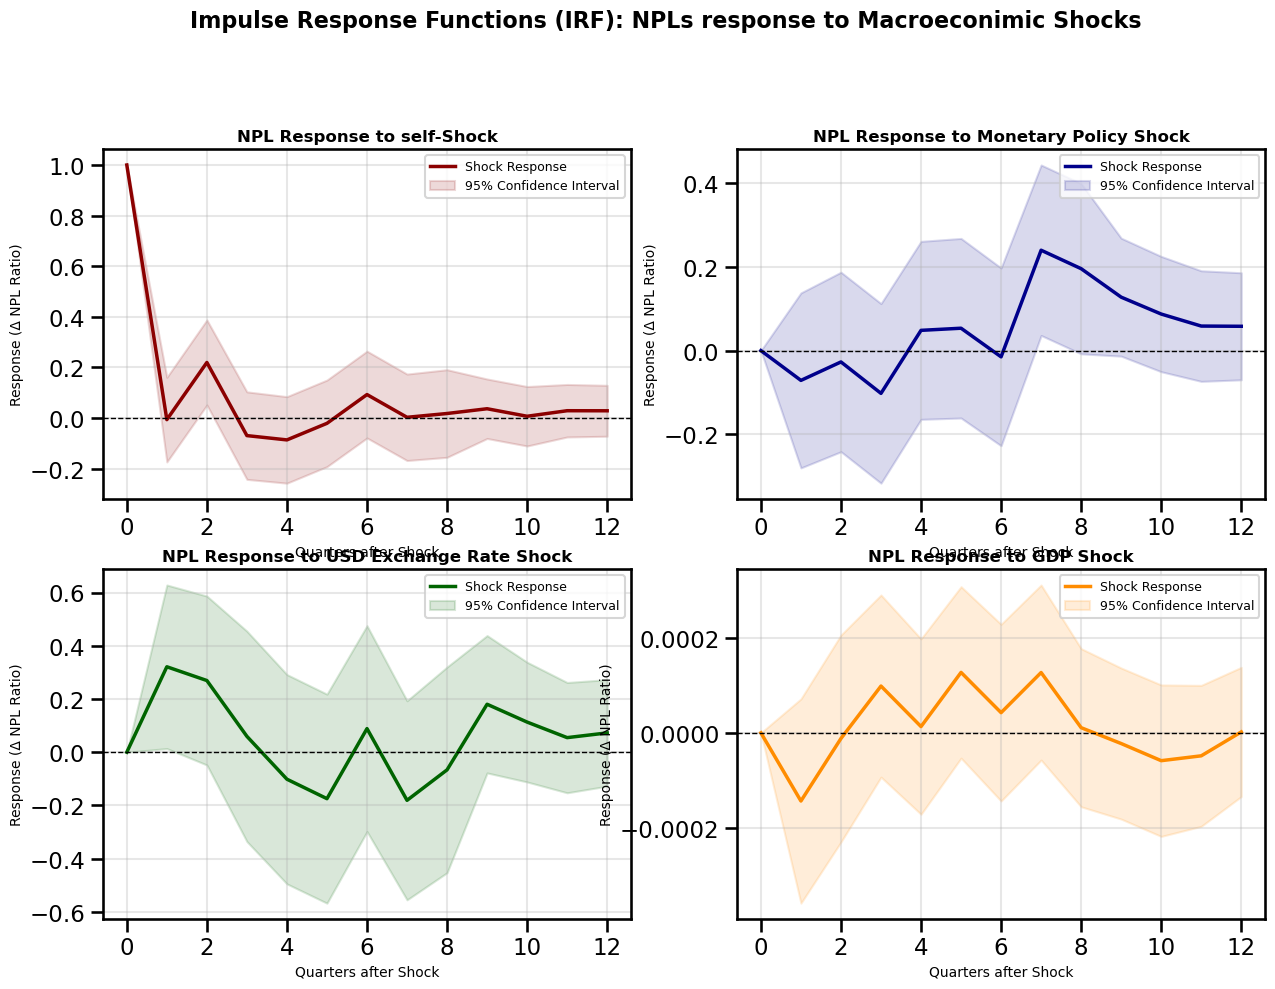

In [9]:
from statsmodels.tsa.api import VAR

# Vector Autoregression (VAR) Model - Shock Propagation Analysis

print("\n" + "=" * 70)
print("SHOCK PROPAGATION ANALYSIS - Vector Autoregression (VAR) Model")
print("=" * 70)

# using first differences for non-stationary variables
var_data = df[['Non Performing Loan Ratio', 'Monetary Policy Rate (%)', 
               'USD Exchange Rate, monthly averages', 'GDP_Real']].copy()

# first differences
var_data_diff = var_data.diff().dropna()

var_model = VAR(var_data_diff)
select_lag = var_model.select_order(maxlags=8)
optimal_lag = select_lag.aic
fit_lag = optimal_lag if optimal_lag > 0 else 2 
var_results = var_model.fit(fit_lag)

print(f"\nVAR Model fitted with {fit_lag} optimal lags (based on AIC)")
print(var_results.summary())



# impulse response function (IRF) - how shocks propagate
print("\n" + "=" * 70)
print("IMPULSE RESPONSE ANALYSIS - Shock Propagation Effects")
print("=" * 70)
periods = 12
irf = var_results.irf(periods)  # 12 months horizon

# Response of NPL Ratio to shocks in key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

def plot_irf_refined(ax, impulse_idx, title, color):
    # Response of NPL (Index 0) to a specific impulse
    response = irf.irfs[:, 0, impulse_idx]
  
    standard_errors = irf.stderr()[:, 0, impulse_idx]
    lower_bound = response - 1.96 * standard_errors
    upper_bound = response + 1.96 * standard_errors
    
    # Plotting
    ax.plot(response, linewidth=2.5, color=color, label='Shock Response')
    ax.fill_between(range(periods + 1), lower_bound, upper_bound, 
                    color=color, alpha=0.15, label='95% Confidence Interval')
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('Quarters after Shock', fontsize=10)
    ax.set_ylabel('Response (Δ NPL Ratio)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.legend(loc='upper right', fontsize=9)

# Execute Plots in your 2x2 grid
plot_irf_refined(axes[0, 0], 0, 'NPL Response to self-Shock', 'darkred')
plot_irf_refined(axes[0, 1], 1, 'NPL Response to Monetary Policy Shock', 'darkblue')
plot_irf_refined(axes[1, 0], 2, 'NPL Response to USD Exchange Rate Shock', 'darkgreen')
plot_irf_refined(axes[1, 1], 3, 'NPL Response to GDP Shock', 'darkorange')

plt.suptitle('Impulse Response Functions (IRF): NPLs response to Macroeconimic Shocks', 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig('../figures/irf_npl_shocks.png', bbox_inches='tight')
plt.show()



By transitioning from OLS to a VAR framework, this project demonstrates the ability to model lagged economic causality. The findings provide a quantitative basis for Early Warning Systems, allowing financial institutions to anticipate spikes in credit risk based on current volatility in the foreign exchange market